In [1]:
# from __future__ import print_function
from numpy.random import seed

# TensorFlow and tf.keras
import tensorflow as tf
import tensorflow.keras as keras

from DataGenerator import DataGenerator
from i3d_inception import *
from utils import *

# Helper libraries
seed(1)
import numpy as np
import matplotlib
import math

matplotlib.use('Agg')
from matplotlib import pyplot as plt
import os

from keras.models import load_model, Model, Sequential
from keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Activation, Dense, Dropout, ZeroPadding2D)
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, auc, roc_curve
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from scipy import interp
from keras.layers.advanced_activations import ELU

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import keras.backend as K

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Using TensorFlow backend.

Bad key "text.kerning_factor" on line 4 in
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# CHANGE THESE VARIABLES ---
save_plots = True
use_checkpoint = True # Set to True or False

# Paths
best_model_path = 'test/'
plots_folder = 'plots/'

# Hyper parameters
batch_norm = False
gpu_num = 1 
learning_rate = 0.01
mini_batch_size = 1
weight_0 = 1 # higher weight of 0 prioritizes learning in class 0
epochs = 60
dropout_prob=0.36

# Input dimensions
NUM_FRAMES = 64
FRAME_HEIGHT = 224
FRAME_WIDTH = 224
NUM_RGB_CHANNELS = 3
NUM_CLASSES = 2

optimizer = 'adam'
weights = "rgb_imagenet_and_kinetics"
name = 'LOSO'

# Name of the experiment
exp = '_lr{}_batchs{}_batchnorm{}_w0_{}_{}_{}'.format(learning_rate,
                                                      mini_batch_size,
                                                      batch_norm,
                                                      weight_0, 
                                                      name,
                                                      weights)

In [3]:
# Experiments
# 1. Only with hazardous slips (with more data you gathered) --> 60:60--> same as last time with more data
# 2. Only with normal slips and 'no slips' --> 60:60 --> this can be a fair detection 
# 3. Combination of 1+2 --> 120:120
# 4. With small slips --> 60:60
# 5. With all dataset --> 180:180

experiments = {'exp1':['Hazardous_slips', 'Pass_split1'],
               'exp2':['Normal_slips', 'Pass_split1'],
               'exp3':['Hazardous_slips', 'Normal_slips', 'Pass_split1', 'Pass_split2'],
               'exp4':['Small_slips', 'Pass_split1'],
               'exp5':['Hazardous_slips', 'Normal_slips', 'Pass_split1', 'Pass_split2', 'Small_slips', 'Pass_split3']
              }

exp_name = 'exp5' 

# Make sure you change ROC manually
# Learning rate
# Memory usage
# Patience
# ROC title and name
# Not use check model
# main function argument

In [4]:
# Loading model checkpoints  
exp = exp_name + exp
threshold = 0.5

# Import data
classes = list_data(exp_name, experiments)
class0, class1 = classes['fail'], classes['pass']

X_full = np.expand_dims((class0 + class1), axis=1)
_y_full = np.concatenate(((np.zeros(shape = (len(class0),1))), np.ones(shape = (len(class1),1))))
sub_full = np.asarray(extract_subID((class0 + class1)))

temp = sorted(zip(X_full, _y_full), key=lambda x: x[0][0][12:15])
X_full = np.asarray([item[0] for item in temp])
_y_full = np.asarray([item[1] for item in temp])
sub_full.sort()
sub_full = np.unique(sub_full)

#     sensitivities, specificities = [], []
#     fars, mdrs, accuracies = [], [], []
#     f1s = []  

predictions, samples = [], [] # To record all prediction values
tps, tns , fps, fns = [], [], [], []
fold_number = 1 

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots() # For ROC
from matplotlib.pyplot import cm
color=iter(cm.rainbow(np.linspace(0,1,18)))

# CROSS-VALIDATION: Stratified partition of the dataset into train/test sets
from sklearn.model_selection import LeaveOneOut, train_test_split
loo = LeaveOneOut()

for train_index, test_index in loo.split(sub_full):
    sub_train, sub_test = sub_full[train_index], sub_full[test_index]

    # Find the data matching subject ID
    X_full, _y_full = X_full.flatten(), _y_full.flatten()
    index_train = [False if sub_test[0] in x else True for x in X_full]
    index_test = [True if sub_test[0] in x else False for x in X_full]
    X_train, y_train = X_full[index_train], _y_full[index_train]
    X2, _y2 = X_full[index_test], _y_full[index_test]
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, 
                                                      test_size=0.1, random_state=42)

    # Generators
    training_generator = DataGenerator(X_train, y_train, mini_batch_size*gpu_num)
    validation_generator = DataGenerator(X_val, y_val, mini_batch_size*gpu_num)

    reset_keras()
    model = build_model()
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(adam, loss='binary_crossentropy', metrics=['accuracy'])

    # ==================== EVALUATION ========================

    # Load best model
    print('\nModel loaded from checkpoint')
    print(sub_test[0])

    fold_best_model_path = best_model_path + exp + '_MAA_fold_{}.h5'.format(fold_number)
    model = load_model(fold_best_model_path)
    test_generator = DataGenerator(X2, _y2, shuffle=False)

    predicted = model.predict_generator(test_generator)
    y_score = np.copy(predicted)
    predicted = predicted[:,1]
    predictions.append(y_score)
    samples.append(_y2)

    for i in range(len(predicted)):
        if predicted[i] < threshold:
            predicted[i] = 0
        else:
            predicted[i] = 1

    # Array of predictions 0/1
    predicted = np.asarray(predicted).astype(int)

    # Compute metrics and print them
    cm = confusion_matrix(_y2, predicted, labels=[0, 1])
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]

    tps.append(tp)
    tns.append(tn)
    fps.append(fp)
    fns.append(fn)

    tpr = tp / float(tp + fn)
    fpr = fp / float(fp + tn)
    fnr = fn / float(fn + tp)
    tnr = tn / float(tn + fp)
    accuracy = accuracy_score(_y2, predicted)
    precision = tp / float(tp + fp)
    recall = tp / float(tp + fn)
    specificity = tn / float(tn + fp)

    try:
        f1 = 2 * float(precision * recall) / float(precision + recall)                
    except:
        f1 = 0
        print("An exception occurred")

    print('FOLD {} results:'.format(fold_number))
    print('TP: {}, TN: {}, FP: {}, FN: {}'.format(tp, tn, fp, fn))
    print('TPR: {}, TNR: {}, FPR: {}, FNR: {}'.format(tpr, tnr, fpr, fnr))
    print('Sensitivity/Recall: {}'.format(recall))
    print('Specificity: {}'.format(specificity))
    print('Precision: {}'.format(precision))
    print('F1-measure: {}'.format(f1))
    print('Accuracy: {}'.format(accuracy))
    print('\n')

    # Binarize the output
    _y2 = label_binarize(_y2, classes=[1, 0])
    n_classes = _y2.shape[1] 

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(_y2[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    lw = 2
    c = next(color)
    font = {'family' : 'Palatino Linotype', 'size':  13}
    plt.rc('font', **font)
    
    plt.plot(fpr[0], tpr[0],
             lw=lw, color=c,
             label= 'Leave {}'.format(sub_test[0]) + ' out ' + '(area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontfamily= 'Palatino Linotype', fontsize= 13)
    plt.ylabel('True Positive Rate', fontfamily= 'Palatino Linotype', fontsize= 13)
    plt.title('LOSO Experiment ROC Curves of Class Slips', fontfamily= 'Palatino Linotype')
    plt.legend(loc="lower right")

    # ROC curve plotting
    interp_tpr = np.interp(mean_fpr, fpr[0], tpr[0])
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc[0])

#                 font = {'family' : 'Palatino Linotype', 'size':  10}
#                 plt.rc('font', **font)

#             # ROC curve plotting
#             interp_tpr = np.interp(mean_fpr, fpr[0], tpr[0])
#             interp_tpr[0] = 0.0
#             tprs.append(interp_tpr)
#             aucs.append(roc_auc[0])
#             # Store the metrics for this fold
#             sensitivities.append(recall)
#             specificities.append(specificity)
#             fars.append(fpr)
#             mdrs.append(fnr)
#             accuracies.append(accuracy)
#             f1s.append(f1)

    fold_number += 1


# ROC
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],)
ax.legend(loc="lower right", fontsize= 'xx-small')

plt.show()
plt.savefig('ROC for LOSO Experiment')










Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Model loaded from checkpoint
sub207


C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)




FOLD 1 results:
TP: 5, TN: 3, FP: 0, FN: 0
TPR: 1.0, TNR: 1.0, FPR: 0.0, FNR: 0.0
Sensitivity/Recall: 1.0
Specificity: 1.0
Precision: 1.0
F1-measure: 1.0
Accuracy: 1.0




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub228
FOLD 2 results:
TP: 1, TN: 6, FP: 0, FN: 8
TPR: 0.1111111111111111, TNR: 1.0, FPR: 0.0, FNR: 0.8888888888888888
Sensitivity/Recall: 0.1111111111111111
Specificity: 1.0
Precision: 1.0
F1-measure: 0.19999999999999998
Accuracy: 0.4666666666666667




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub232
FOLD 3 results:
TP: 6, TN: 2, FP: 0, FN: 1
TPR: 0.8571428571428571, TNR: 1.0, FPR: 0.0, FNR: 0.14285714285714285
Sensitivity/Recall: 0.8571428571428571
Specificity: 1.0
Precision: 1.0
F1-measure: 0.923076923076923
Accuracy: 0.8888888888888888




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub237


c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


FOLD 4 results:
TP: 0, TN: 6, FP: 1, FN: 0
TPR: nan, TNR: 0.8571428571428571, FPR: 0.14285714285714285, FNR: nan
Sensitivity/Recall: nan
Specificity: 0.8571428571428571
Precision: 0.0
F1-measure: nan
Accuracy: 0.8571428571428571




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub243
FOLD 5 results:
TP: 2, TN: 5, FP: 0, FN: 1
TPR: 0.6666666666666666, TNR: 1.0, FPR: 0.0, FNR: 0.3333333333333333
Sensitivity/Recall: 0.6666666666666666
Specificity: 1.0
Precision: 1.0
F1-measure: 0.8
Accuracy: 0.875




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub244
FOLD 6 results:
TP: 15, TN: 12, FP: 0, FN: 10
TPR: 0.6, TNR: 1.0, FPR: 0.0, FNR: 0.4
Sensitivity/Recall: 0.6
Specificity: 1.0
Precision: 1.0
F1-measure: 0.7499999999999999
Accuracy: 0.7297297297297297




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub245


c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in true_divide
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in true_divide
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in true_divide
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:102: RuntimeWarning: invalid value encountered in true_divide
c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\sklearn\metrics\_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


FOLD 7 results:
TP: 0, TN: 18, FP: 0, FN: 0
TPR: nan, TNR: 1.0, FPR: 0.0, FNR: nan
Sensitivity/Recall: nan
Specificity: 1.0
Precision: nan
F1-measure: nan
Accuracy: 1.0




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub247
FOLD 8 results:
TP: 1, TN: 8, FP: 0, FN: 0
TPR: 1.0, TNR: 1.0, FPR: 0.0, FNR: 0.0
Sensitivity/Recall: 1.0
Specificity: 1.0
Precision: 1.0
F1-measure: 1.0
Accuracy: 1.0




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub248
FOLD 9 results:
TP: 16, TN: 10, FP: 1, FN: 5
TPR: 0.7619047619047619, TNR: 0.9090909090909091, FPR: 0.09090909090909091, FNR: 0.23809523809523808
Sensitivity/Recall: 0.7619047619047619
Specificity: 0.9090909090909091
Precision: 0.9411764705882353
F1-measure: 0.8421052631578947
Accuracy: 0.8125




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub249
FOLD 10 results:
TP: 15, TN: 7, FP: 2, FN: 3
TPR: 0.8333333333333334, TNR: 0.7777777777777778, FPR: 0.2222222222222222, FNR: 0.16666666666666666
Sensitivity/Recall: 0.8333333333333334
Specificity: 0.7777777777777778
Precision: 0.8823529411764706
F1-measure: 0.8571428571428571
Accuracy: 0.8148148148148148




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub251
FOLD 11 results:
TP: 3, TN: 6, FP: 0, FN: 5
TPR: 0.375, TNR: 1.0, FPR: 0.0, FNR: 0.625
Sensitivity/Recall: 0.375
Specificity: 1.0
Precision: 1.0
F1-measure: 0.5454545454545454
Accuracy: 0.6428571428571429




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub252
FOLD 12 results:
TP: 8, TN: 4, FP: 0, FN: 2
TPR: 0.8, TNR: 1.0, FPR: 0.0, FNR: 0.2
Sensitivity/Recall: 0.8
Specificity: 1.0
Precision: 1.0
F1-measure: 0.888888888888889
Accuracy: 0.8571428571428571




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub253
FOLD 13 results:
TP: 5, TN: 16, FP: 1, FN: 5
TPR: 0.5, TNR: 0.9411764705882353, FPR: 0.058823529411764705, FNR: 0.5
Sensitivity/Recall: 0.5
Specificity: 0.9411764705882353
Precision: 0.8333333333333334
F1-measure: 0.625
Accuracy: 0.7777777777777778




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub254
FOLD 14 results:
TP: 4, TN: 5, FP: 0, FN: 1
TPR: 0.8, TNR: 1.0, FPR: 0.0, FNR: 0.2
Sensitivity/Recall: 0.8
Specificity: 1.0
Precision: 1.0
F1-measure: 0.888888888888889
Accuracy: 0.9




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub255
FOLD 15 results:
TP: 13, TN: 23, FP: 2, FN: 3
TPR: 0.8125, TNR: 0.92, FPR: 0.08, FNR: 0.1875
Sensitivity/Recall: 0.8125
Specificity: 0.92
Precision: 0.8666666666666667
F1-measure: 0.8387096774193549
Accuracy: 0.8780487804878049




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub263
FOLD 16 results:
TP: 16, TN: 13, FP: 0, FN: 4
TPR: 0.8, TNR: 1.0, FPR: 0.0, FNR: 0.2
Sensitivity/Recall: 0.8
Specificity: 1.0
Precision: 1.0
F1-measure: 0.888888888888889
Accuracy: 0.8787878787878788




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub264
FOLD 17 results:
TP: 9, TN: 15, FP: 3, FN: 0
TPR: 1.0, TNR: 0.8333333333333334, FPR: 0.16666666666666666, FNR: 0.0
Sensitivity/Recall: 1.0
Specificity: 0.8333333333333334
Precision: 0.75
F1-measure: 0.8571428571428571
Accuracy: 0.8888888888888888




C:\Users\kentw\OneDrive - University of Toronto\PycharmProjects\keras-kinetics-i3d\utils.py:208: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`
  return Model(input=model.input, output=x)



Model loaded from checkpoint
sub265
FOLD 18 results:
TP: 7, TN: 11, FP: 0, FN: 6
TPR: 0.5384615384615384, TNR: 1.0, FPR: 0.0, FNR: 0.46153846153846156
Sensitivity/Recall: 0.5384615384615384
Specificity: 1.0
Precision: 1.0
F1-measure: 0.7000000000000001
Accuracy: 0.75




c:\users\kentw\appdata\local\continuum\anaconda3\envs\keras-kinetics-i3d\lib\site-packages\ipykernel_launcher.py:179: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [5]:
tp = sum(tps)
fn = sum(fns)
fp = sum(fps)
tn = sum(tns)    
accuracy = float(tp + tn) / float(tp + tn + fn + fp)
precision = tp / float(tp + fp)
recall = tp / float(tp + fn)
specificity = tn / float(tn + fp) 
f1 = 2 * float(precision * recall) / float(precision + recall)   
fpr = fp / float(fp + tn)
fnr = fn / float(fn + tp)

print('18-FOLD CROSS-VALIDATION RESULTS ===================')
print("Sensitivity: %.2f" % recall)
print("Specificity: %.2f" % specificity)
print("FAR: %.2f" % fpr)  # False alarm rates 
print("MDR: %.2f" % fnr)  # Missed detection rates
print("Accuracy: %.2f" % accuracy)
print("F1: %.2f" % f1)

18-FOLD CROSS-VALIDATION RESULTS ===================
Sensitivity: 0.70
Specificity: 0.94
FAR: 0.06
MDR: 0.30
Accuracy: 0.82
F1: 0.80


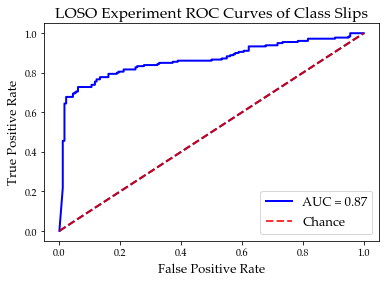

In [6]:
%matplotlib inline
y_score = np.vstack(predictions)
samples = np.hstack(samples)

# LOOCV
tprs = []
aucs = []  
mean_fpr = np.linspace(0, 1, 100)
fig, ax = plt.subplots() # For ROC

# Binarize the output
_y2 = label_binarize(samples, classes=[1, 0])
n_classes = _y2.shape[1] 

fpr = dict()
tpr = dict()
roc_auc = dict()

font = {'family' : 'Palatino Linotype', 'size':  13}
plt.rc('font', **font)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(_y2[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

lw = 2
plt.plot(fpr[0], tpr[0],
         lw=lw, color='b',
         label= 'AUC = %0.2f' % roc_auc[0])

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontfamily= 'Palatino Linotype', fontsize= 13)
plt.ylabel('True Positive Rate', fontfamily= 'Palatino Linotype', fontsize= 13)
plt.title('LOSO Experiment ROC Curves of Class Slips', fontfamily= 'Palatino Linotype')
plt.legend(loc="lower right")

# ROC curve plotting
interp_tpr = np.interp(mean_fpr, fpr[0], tpr[0])
interp_tpr[0] = 0.0
tprs.append(interp_tpr)
aucs.append(roc_auc[0])

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],)
ax.legend(loc="lower right", fontsize= 'medium')

plt.savefig('ROC for LOSO Experiment test')
plt.show()